## Some tests about the monolithic preprocessor

In [1]:
import numpy as np
import torch
from preprocess.monolith import find_ids, find_halo

# First utility of the module is the find_ids function. It returns an array of integers.
ids = find_ids(
    base_path='dataset/TNG100-3/output',
    hsmall=0.6774,
    snap_num=99,
    mass_min=1000000000000.0,
    mass_max=5000000000000.0,
    n_gas_min=500,
)
assert isinstance(ids, np.ndarray)
assert ids.dtype == np.int64

# Secondly, with a loop over all indexes, find_halo build two array of NUM_PARTICLES rows and 4 columns (X, Y, Z, MASS).
dm_halo, gas_halo = find_halo(
    base_path='dataset/TNG100-3/output',
    halo_id=ids[0],
    lbox=75000.0,
    mdm=472394449.36521995,
    snap_num=99
)

# X, Y and Z can be positive ore negative, because they are relative to the center of mass of the halo. Masses in `dm_halo` are always equal to `mdm / 1e10` and masses of `gas_halo` varies.
print("Dark matter particles")
print(dm_halo)

print("Gas particles")
print(gas_halo)

Dark matter particles
[[ 1.04231418e+01 -6.40194738e+00 -1.61657979e+00  4.72394449e-02]
 [ 1.13459913e+01 -5.95776642e+00 -1.21491853e+00  4.72394449e-02]
 [ 9.68148905e+00 -6.86386136e+00 -2.07751967e+00  4.72394449e-02]
 ...
 [ 3.41927230e+01  8.02075748e+01 -2.03665752e+01  4.72394449e-02]
 [-1.10674581e+02  6.11351384e+01 -1.89990026e+00  4.72394449e-02]
 [-1.61922891e+02  1.69029178e+02 -4.71163264e+00  4.72394449e-02]]
Gas particles
[[ 1.26990368e+01 -4.45786014e+00 -8.95605058e+00  1.22793103e-02]
 [ 9.98359735e+00 -2.65588877e+00 -1.13402028e+01  6.87742047e-03]
 [ 1.86737134e+01 -2.95313115e+00 -1.08345178e+01  1.32554537e-02]
 ...
 [ 5.34092582e+01 -8.21173002e+01 -6.43312808e+01  5.61451446e-03]
 [ 6.79069628e+01 -8.59964206e+01 -6.93208099e+01  8.22646916e-03]
 [-7.93876567e+01  1.17252220e+02  1.54833089e+01  7.14536477e-03]]


In [2]:
# To test if position are really relative to the center of mass, we can sum all positions od dm_halo, because they have all the same weight.
print("Center of dark matter", np.sum(dm_halo[:, :3], axis=0))

# Maybe the center of mass is calculated considering dark matter and gas together. Let's weight the positions and sum them.
dm_wpos = (dm_halo[:,:3] * dm_halo[:,3].reshape((-1,1)))
gas_wpos = (gas_halo[:,:3] * gas_halo[:,3].reshape((-1,1)))

print("Weighted center of dark matter", np.sum(dm_wpos, axis=0))
print("Weighted center of gas", np.sum(gas_wpos, axis=0))
print("Weighted center combined", np.sum(np.vstack([dm_wpos, gas_wpos]), axis=0))

# Maybe weights are not the same for dark matter and gas, but no factor can sum the two negative x to 0...

Center of dark matter [-1264.38641317  2225.41274029  1976.13679177]
Weighted center of dark matter [-59.72891234 105.12726261  93.35160516]
Weighted center of gas [-27.61739674 -34.16789986 -48.68320766]
Weighted center combined [-87.34630908  70.95936274  44.6683975 ]


In [3]:
# ... so they are not the positions relative to the center of mass. Nevertheless they are positions.
# Doing what voxelize would do we first split the input
dm_pos, dm_mass = dm_halo[:, 0:3], dm_halo[:, 3]
gas_pos, gas_mass = gas_halo[:, 0:3], gas_halo[:, 3]
print(dm_pos)

[[  10.42314178   -6.40194738   -1.61657979]
 [  11.34599131   -5.95776642   -1.21491853]
 [   9.68148905   -6.86386136   -2.07751967]
 ...
 [  34.19272299   80.20757477  -20.36657519]
 [-110.6745806    61.13513837   -1.89990026]
 [-161.92289109  169.02917842   -4.71163264]]


In [4]:
# Shift positions to have no negatives
minimum = min(np.min(dm_pos), np.min(gas_pos))
dm_pos = dm_pos - minimum
gas_pos = gas_pos - minimum
print(dm_pos)

[[237.74349354 220.91840438 225.70377197]
 [238.66634307 221.36258534 226.10543323]
 [237.00184081 220.4564904  225.24283209]
 ...
 [261.51307475 307.52792653 206.95377657]
 [116.64577116 288.45549013 225.42045149]
 [ 65.39746066 396.34953017 222.60871912]]


In [5]:
# Resize to nvoxel and floor
nvoxel = 256
maximum = max(np.max(dm_pos), np.max(gas_pos))
dm_pos = np.floor(dm_pos * (nvoxel - 1) / maximum).astype(np.int64)
gas_pos = np.floor(gas_pos * (nvoxel - 1) / maximum).astype(np.int64)
print(dm_pos)

[[129 120 122]
 [130 120 123]
 [129 120 122]
 ...
 [142 167 112]
 [ 63 157 122]
 [ 35 215 121]]


In [6]:
# Then voxelize take the position as indices and the masses as values of a sparse uncoalesced tensor (see https://pytorch.org/docs/stable/sparse.html#sparse-uncoalesced-coo-docs)
# Positions are transposed because that's the way torch wants them: columns of indices are the rows of dm_pos.
dm_uncoalesced = torch.sparse_coo_tensor(
    indices=dm_pos.T, values=dm_mass, size=(nvoxel, nvoxel, nvoxel)
)
print(dm_uncoalesced)

tensor(indices=tensor([[129, 130, 129,  ..., 142,  63,  35],
                       [120, 120, 120,  ..., 167, 157, 215],
                       [122, 123, 122,  ..., 112, 122, 121]]),
       values=tensor([0.0472, 0.0472, 0.0472,  ..., 0.0472, 0.0472, 0.0472]),
       size=(256, 256, 256), nnz=7886, dtype=torch.float64,
       layout=torch.sparse_coo)


In [7]:
# Finally, these tensors are coalesced: values with the same index are summed. Check this out
uncoalesced = torch.sparse_coo_tensor(
    indices=[[0, 0, 2],
             [1, 1, 2],
             [1, 1, 0]],
    values=[1.0, 5.0, 8.0],
    size=(4, 4, 4)
)
coalesced = uncoalesced.coalesce()
print("uncoalesced:\n", uncoalesced)
print("coalesced:\n", coalesced)

uncoalesced:
 tensor(indices=tensor([[0, 0, 2],
                       [1, 1, 2],
                       [1, 1, 0]]),
       values=tensor([1., 5., 8.]),
       size=(4, 4, 4), nnz=3, layout=torch.sparse_coo)
coalesced:
 tensor(indices=tensor([[0, 2],
                       [1, 2],
                       [1, 0]]),
       values=tensor([6., 8.]),
       size=(4, 4, 4), nnz=2, layout=torch.sparse_coo)


In [8]:
# These tensors are then saved as .npy and than later converted into dense tensors by the dataset.
# In this way we avoid saving the intermediate filse about the whole unprocessed halos.
# Storing tensors in sparse format save orders of magnitude in disk space: a tipical dark matter halo has around 1e5 particles (in TNG100-3), but a tensor of shape [256, 256, 256] has 1.67e7 elements
# Using .npy format (which is binary) instead of .csv (which is textual) save more or less 50% of disk space.

## Questions of visualization

In [49]:
x = torch.load("data/TNG100-3_SNAP099_MASS1.00e+12_5.00e+12_NGASMIN500/nvoxel_64/test/halo_14585_coalesced.npy")["dm"]
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

len(x.coalesce().values())
# sns.set(style = "darkgrid")
# pos = x.coalesce().indices()
# mass = x.coalesce().values()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(pos[0], pos[1], pos[2], marker=".", alpha=mass/10)
# plt.show()



3832

695


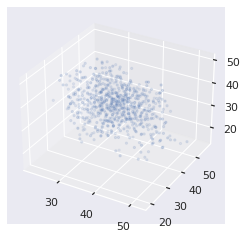

torch.Size([3, 695]) torch.Size([695])


(tensor(0.0120, dtype=torch.float64), tensor(0.0031, dtype=torch.float64))

In [50]:
x = torch.load("data/TNG100-3_SNAP099_MASS1.00e+12_5.00e+12_NGASMIN500/nvoxel_64/test/halo_14585_coalesced.npy")["gas"]
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

print(len(x.coalesce().values()))

sns.set(style = "darkgrid")
pos = x.coalesce().indices()
mass = x.coalesce().values()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pos[0], pos[1], pos[2], marker=".", alpha=mass*20)
plt.show()

print(pos.shape, mass.shape)
max(mass), min(mass)

[ 0.00173658 -0.01024676 -0.00327989  0.00247455 -0.00118382  0.00214647
  0.00586736  0.01429723  0.00744334  0.0014654  -0.00077565 -0.0022326
 -0.00370855 -0.00507165 -0.00683584 -0.00423903]


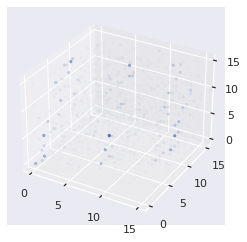

In [38]:
from pathlib import Path
s = torch.load(Path("runs") / "sample_590.npy")
x = (s["pg"][8,0,:,:,:]).detach().cpu().numpy()

print(np.mean(x, axis=(0, 1)))
import matplotlib.pyplot as plt
import numpy as np
import itertools

l = len(x)
sns.set(style = "darkgrid")
pos = list(itertools.product(range(0, l), range(0, l), range(0, l)))
mass = np.array([ x[p] for p in pos ])
mass = np.maximum(mass, 0) / np.max(mass)
pos = np.array(pos).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pos[0], pos[1], pos[2], marker=".", alpha=mass)
plt.show()

## Running the gan with different parameters and architectures a evalute the outcomes on small scale simulations.

### Not ready yet

Run the simulations with
```
python main.py
```

Options are read from `defaults.py` and overridden by options in an `options.py` file, if present. So copy and rename `defaults.py` without modifying it and change options in `options.py`.

If an option is a list, e.g. `generator_depth = [4, 5, 6]`, the program will run multiple times with different parameters, logging the results. Attention: making to many parameters into a list may take long time because the program will run every combination in the cartesian product.

Process is logged in `last_run.log` and metrics about the runs are saved in `last_run.csv`.

In [ ]:
import numpy as np
import seaborn as sb
import pandas as pd
from random import randint, choice
import torch
from importlib import reload
import os
import glob
from types import SimpleNamespace
import logging
import visualization

In [ ]:
gm = pd.read_csv("run_f60d59e38c0aa769a21e60b05bb7c89f/global_metrics.csv")
g = sb.FacetGrid(gm, col="discriminator")
g.map(sb.lineplot, "epoch", "l1")
# g.map(sb.scatterplot, "epoch", "mse")


In [ ]:
data = np.random.default_rng(42).random((20, 3))
df = pd.DataFrame(data, columns=["time", "height", "width"])
df[["time", "width"]]